## Package import statements only

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date

from   scipy.optimize import curve_fit
from   sklearn.linear_model import LinearRegression


%matplotlib inline

## File imports only

In [133]:
og_county_covid_df = pd.read_csv('/Users/josephgreene/Library/CloudStorage/Box-Box/project_county_covid_data')
og_county_internet_df = pd.read_csv('/Users/josephgreene/GitHub/INFO2950Project/project_county_internet_data')

### DF resets

In [134]:
county_covid_df = og_county_covid_df.copy()
county_internet_df = og_county_internet_df.copy()

# County Level

## Classification prediction model: Covid response grade and Internet access grade
1. Qcut the data
    - Qcut death_rate into bins
    - Qcut internet (create formula for internet access to account for avg. speed, # providers @ high//low speeds
2. Turn gradings into dummy col. (use OneHotEncoder)
3. Classification prediction
    - 

### Significance test: Bootstraps

## Linear regression model: Death rate and Average internet speed
1. Do linear regression model (linear)
    - drop nans (death_rate and avg mbps)
    - create LinearRegression obj.
    - fit data
    
2. Do non-linear (ex decay?) model
    - get log of death rate
    - create linearRegression on x(avg mbps) and y(log(death_rate))


### Significant test: Permutations w/ 95% CI

# County Level

## Linear Regression Model

In [135]:
# Cleaning the county (covid) data

county_covid_df['date'] = pd.to_datetime(county_covid_df['date'])
county_covid_df.drop(columns='Unnamed: 0',inplace=True)
current_covid = county_covid_df.loc[county_covid_df.date == county_covid_df.date.max()].copy()
current_covid['death_rate'] = current_covid['tot_deaths'] / current_covid['tot_cases']
current_covid.drop(columns=[
    'cases',
    'cases_avg',
#     'cases_avg_per_100k',
    'deaths',
    'deaths_avg',
#     'deaths_avg_per_100k'
],inplace=True)

In [142]:
# county_df is the most recent Covid data merged with internet data by county

county_df = pd.merge(current_covid,county_internet_df,on='fips_code',how='left')
print(county_df.shape)

(3249, 14)


In [143]:
county_df.fips_code.size

3249

In [144]:
county_df

,date,county,state,cases_avg_per_100k,deaths_avg_per_100k,tot_deaths,tot_cases,death_rate,fips_code,dr_rating,AverageMbps,FastestAverageMbps,avg_mbps_rating,fast_mbps_rating
0,2021-11-17,Magoffin,Kentucky,108.07,0.00,23,2338,0.009837,21153,1.0,38.095000,89.645000,3.0,3.0
1,2021-11-17,McLean,Kentucky,31.03,1.55,345,27627,0.012488,21149,1.0,139.460000,287.635000,5.0,5.0
2,2021-11-17,McCreary,Kentucky,32.33,0.00,59,3843,0.015353,21147,2.0,106.620000,165.947500,5.0,5.0
3,2021-11-17,McCracken,Kentucky,20.31,0.22,181,10416,0.017377,21145,3.0,76.820000,192.900000,5.0,5.0
4,2021-11-17,Mason,Kentucky,30.96,0.84,322,19109,0.016851,21161,2.0,27.895000,73.150000,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244,2021-11-17,Canadian,Oklahoma,19.84,0.00,295,23744,0.012424,40017,1.0,120.324286,269.862857,5.0,5.0
3245,2021-11-17,Caddo,Oklahoma,12.42,0.00,1107,45150,0.024518,40015,4.0,37.053333,66.921111,3.0,2.0
3246,2021-11-17,Bryan,Oklahoma,20.54,0.00,180,15443,0.011656,40013,1.0,20.000000,40.835000,1.0,1.0
3247,2021-11-17,Cotton,Oklahoma,27.73,0.00,23,1006,0.022863,40033,4.0,64.687500,152.905000,5.0,4.0


<AxesSubplot:xlabel='AverageMbps', ylabel='death_rate'>

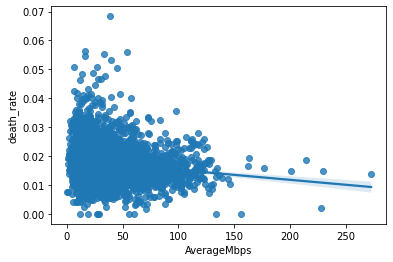

In [172]:
sns.regplot(
    x='AverageMbps',
    y='death_rate',
    data=county_df,
    
)

<AxesSubplot:ylabel='Frequency'>

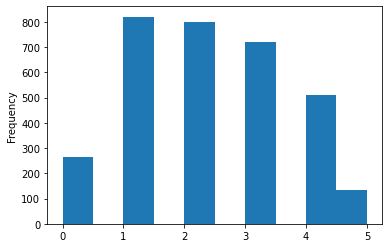

In [167]:
county_df.dr_rating.plot.hist()

<AxesSubplot:ylabel='Frequency'>

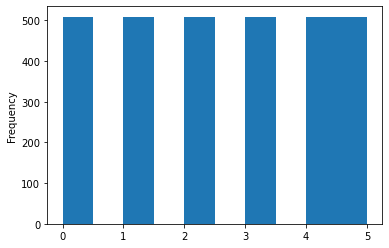

In [168]:
county_internet_df.avg_mbps_rating.plot.hist()